## XGBClassifier пошаговое построение деревьев
в качестве примера самый простой dataset из 15 строк и дерево будет на max_depth=2

Выполним в ручную операции построения простого алгоритма XGBClassifier

In [39]:
import pandas as pd 
import numpy as np

import xgboost as xgb # XGBoost
from sklearn.tree import export_graphviz

from pathlib import Path
from pydotplus import graph_from_dot_data
from IPython.display import Image

In [40]:
data = pd.DataFrame(data={'Age':[12, 87, 44, 56,87, 44, 57, 24, 56, 87, 34, 9, 16, 17, 58], 
                          'y':[1, 1, 0, 0, 1, 1,0, 1, 1, 0, 0,1, 0, 0,1]}, columns=['Age', 'y'])
y = data['y']


X_train = data[['Age']]
data

,Age,y
0,12,1
1,87,1
2,44,0
3,56,0
4,87,1
5,44,1
6,57,0
7,24,1
8,56,1
9,87,0


#### Типовая функция GradientBoostingClassifier 

In [41]:
learning_rate=1
reg_lambda = 1

clf = xgb.XGBClassifier(n_estimators=100, learning_rate=learning_rate, max_depth=2, random_state=0, gamma=0, 
                        reg_lambda=reg_lambda).fit(X_train, y)  
clf.predict(X_train)

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1])

output values считаются в переменных $log(odds)= log(\frac{p}{1-p})$

prediction будет в вероятностях probability
$prediction = \frac{1}{1-exp^{-log(odds)}}$


initial prediction $p$- это вероятность начальная, а output мерится в $log(odds)$ 

если использовать параметр initial = 'zero' значает что у всех будет вероятность 0.5 вне зависимости от долей начальных,
иначе средняя по тренировочному dataset


In [42]:
# initial_prediction = y.mean() 
initial_prediction = 0.5
data['initial_prediction'] = initial_prediction
data['output_0'] = np.log(initial_prediction/(1-initial_prediction))
data['residuals_0'] = data['y'] - initial_prediction

data


,Age,y,initial_prediction,output_0,residuals_0
0,12,1,0.5,0.0,0.5
1,87,1,0.5,0.0,0.5
2,44,0,0.5,0.0,-0.5
3,56,0,0.5,0.0,-0.5
4,87,1,0.5,0.0,0.5
5,44,1,0.5,0.0,0.5
6,57,0,0.5,0.0,-0.5
7,24,1,0.5,0.0,0.5
8,56,1,0.5,0.0,0.5
9,87,0,0.5,0.0,-0.5


первое дерево, которое делает predict residuals_0

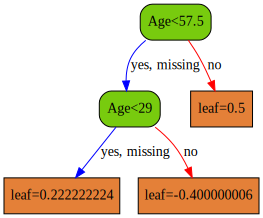

In [43]:
node_params = {'shape': 'box', ## make the nodes fancy
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'} 
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf, num_trees=0, size="4,1", 
                condition_node_params=node_params,
                leaf_node_params=leaf_params) 


теперь посчитаем output values сами

## output = $\frac{\sum_i{Residuals}}{\sum_i{[p_{previous,i}*(1-p_{previous, i})]}+reg\_lambda}$

output в ячейке (суммирование по количеству samples  в листе)   
Residuals - residuals которые попали в лист  
p_{previous,i} - предыдущая вероятность на прошлом дереве у строки, которая попала в лист  

output = $\frac{\sum_i{Residuals}}{\sum{[p_{previous,i}*(1-p_{previous})]}+reg\_lambda}$


In [44]:
# как посчитать output value для  узла 
mask = (data['Age']>57)
data.loc[mask, 'output_1'] =  data.loc[mask, 'residuals_0'].sum()/((data.loc[mask, 'initial_prediction']*(1-data.loc[mask, 'initial_prediction']).sum()+reg_lambda))
data

,Age,y,initial_prediction,output_0,residuals_0,output_1
0,12,1,0.5,0.0,0.5,NaN
1,87,1,0.5,0.0,0.5,0.5
2,44,0,0.5,0.0,-0.5,NaN
3,56,0,0.5,0.0,-0.5,NaN
4,87,1,0.5,0.0,0.5,0.5
5,44,1,0.5,0.0,0.5,NaN
6,57,0,0.5,0.0,-0.5,NaN
7,24,1,0.5,0.0,0.5,NaN
8,56,1,0.5,0.0,0.5,NaN
9,87,0,0.5,0.0,-0.5,0.5


In [45]:
# как посчитать output value для  узла 
mask = (data['Age']<29)
data.loc[mask, 'output_1'] =  data.loc[mask, 'residuals_0'].sum()/((data.loc[mask, 'initial_prediction']*(1-data.loc[mask, 'initial_prediction']).sum()+reg_lambda))
data

,Age,y,initial_prediction,output_0,residuals_0,output_1
0,12,1,0.5,0.0,0.5,0.222222
1,87,1,0.5,0.0,0.5,0.500000
2,44,0,0.5,0.0,-0.5,NaN
3,56,0,0.5,0.0,-0.5,NaN
4,87,1,0.5,0.0,0.5,0.500000
5,44,1,0.5,0.0,0.5,NaN
6,57,0,0.5,0.0,-0.5,NaN
7,24,1,0.5,0.0,0.5,0.222222
8,56,1,0.5,0.0,0.5,NaN
9,87,0,0.5,0.0,-0.5,0.500000


In [46]:
# как посчитать output value для  узла 
mask = (data['Age']<=57)&((data['Age']>29))
data.loc[mask, 'output_1'] =  data.loc[mask, 'residuals_0'].sum()/((data.loc[mask, 'initial_prediction']*(1-data.loc[mask, 'initial_prediction']).sum()+reg_lambda))
data

,Age,y,initial_prediction,output_0,residuals_0,output_1
0,12,1,0.5,0.0,0.5,0.222222
1,87,1,0.5,0.0,0.5,0.500000
2,44,0,0.5,0.0,-0.5,-0.400000
3,56,0,0.5,0.0,-0.5,-0.400000
4,87,1,0.5,0.0,0.5,0.500000
5,44,1,0.5,0.0,0.5,-0.400000
6,57,0,0.5,0.0,-0.5,-0.400000
7,24,1,0.5,0.0,0.5,0.222222
8,56,1,0.5,0.0,0.5,-0.400000
9,87,0,0.5,0.0,-0.5,0.500000


теперь расчитаем на вероятность

In [47]:
output_total = data['output_0'] + learning_rate*data['output_1']
data['prediction_1'] = 1/(1+np.exp(-output_total))
data

,Age,y,initial_prediction,output_0,residuals_0,output_1,prediction_1
0,12,1,0.5,0.0,0.5,0.222222,0.555328
1,87,1,0.5,0.0,0.5,0.500000,0.622459
2,44,0,0.5,0.0,-0.5,-0.400000,0.401312
3,56,0,0.5,0.0,-0.5,-0.400000,0.401312
4,87,1,0.5,0.0,0.5,0.500000,0.622459
5,44,1,0.5,0.0,0.5,-0.400000,0.401312
6,57,0,0.5,0.0,-0.5,-0.400000,0.401312
7,24,1,0.5,0.0,0.5,0.222222,0.555328
8,56,1,0.5,0.0,0.5,-0.400000,0.401312
9,87,0,0.5,0.0,-0.5,0.500000,0.622459


In [48]:
#  сравниваем с реализацией xgb бустинга на первом дереве. ура!!! совпали

individual_preds = []
for tree_ in clf.get_booster():
    individual_preds.append(
        tree_.predict(xgb.DMatrix(X_train))
    )
[round(pred, 6) for pred in  individual_preds[0]]


[0.555328,
 0.622459,
 0.401312,
 0.401312,
 0.622459,
 0.401312,
 0.401312,
 0.555328,
 0.401312,
 0.622459,
 0.401312,
 0.555328,
 0.555328,
 0.555328,
 0.622459]

In [49]:
[round(pred, 6) for pred in  data['prediction_1'].to_list()]

[0.555328,
 0.622459,
 0.401312,
 0.401312,
 0.622459,
 0.401312,
 0.401312,
 0.555328,
 0.401312,
 0.622459,
 0.401312,
 0.555328,
 0.555328,
 0.555328,
 0.622459]

рассчитаем residuals, которые будем минимизировать вторым деревом

In [50]:
data['residuals_1'] = data['y'] - data['prediction_1']

data

,Age,y,initial_prediction,output_0,residuals_0,output_1,prediction_1,residuals_1
0,12,1,0.5,0.0,0.5,0.222222,0.555328,0.444672
1,87,1,0.5,0.0,0.5,0.500000,0.622459,0.377541
2,44,0,0.5,0.0,-0.5,-0.400000,0.401312,-0.401312
3,56,0,0.5,0.0,-0.5,-0.400000,0.401312,-0.401312
4,87,1,0.5,0.0,0.5,0.500000,0.622459,0.377541
5,44,1,0.5,0.0,0.5,-0.400000,0.401312,0.598688
6,57,0,0.5,0.0,-0.5,-0.400000,0.401312,-0.401312
7,24,1,0.5,0.0,0.5,0.222222,0.555328,0.444672
8,56,1,0.5,0.0,0.5,-0.400000,0.401312,0.598688
9,87,0,0.5,0.0,-0.5,0.500000,0.622459,-0.622459
